In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import folium
from folium import plugins
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import datetime as dt
import warnings

pd.options.display.max_columns=100
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
%%time

full_df=pd.read_csv('csv_files/Motor_Vehicle_Collisions_-_Crashes.csv')
zips=geopandas.read_file(r"C:\Users\berid\python\geopandas\tl_2019_us_zcta510_zipcodes\tl_2019_us_zcta510.shp")

CPU times: total: 2min 48s
Wall time: 3min 19s


In [3]:
df=full_df.sample(10**5)

In [4]:
df.columns=df.columns.str.title().str.strip()

In [5]:
df.head()

Crash Date Crash Time   Borough Zip Code   Latitude  Longitude  \
1769340  04/30/2013      18:50     BRONX    10460  40.842066 -73.876085   
220715   07/21/2020      20:00       NaN      NaN  40.657490 -73.893074   
606947   07/15/2018      13:04    QUEENS  11418.0  40.698920 -73.843850   
290638   12/17/2019      12:00    QUEENS  11101.0  40.750645 -73.945660   
1488292  08/11/2014      16:50  BROOKLYN    11216  40.683893 -73.938222   

                         Location                    On Street Name  \
1769340  (40.842066, -73.8760851)  EAST 180 STREET                    
220715     (40.65749, -73.893074)  LINDEN BOULEVARD                   
606947      (40.69892, -73.84385)  105 STREET                         
290638     (40.750645, -73.94566)  21 STREET                          
1488292  (40.6838926, -73.938222)  HANCOCK STREET                     

                        Cross Street Name Off Street Name  \
1769340  DEVOE AVENUE                                 NaN   
220715                     ALABAMA AVENUE             NaN   
606947                          85 AVENUE             NaN   
290638                          43 AVENUE             NaN   
1488292  SUMNER AVENUE                                NaN   

         Number Of Persons Injured  Number Of Persons Killed  \
1769340                        0.0                       0.0   
220715                         0.0                       0.0   
606947                         0.0                       0.0   
290638                         1.0                       0.0   
1488292                        2.0                       0.0   

         Number Of Pedestrians Injured  Number Of Pedestrians Killed  \
1769340                              0                             0   
220715                               0                             0   
606947                               0                             0   
290638                               0                             0   
1488292                              0                             0   

         Number Of Cyclist Injured  Number Of Cyclist Killed  \
1769340                          0                         0   
220715                           0                         0   
606947                           0                         0   
290638                           0                         0   
1488292                          1                         0   

         Number Of Motorist Injured  Number Of Motorist Killed  \
1769340                           0                          0   
220715                            0                          0   
606947                            0                          0   
290638                            1                          0   
1488292                           1                          0   

          Contributing Factor Vehicle 1   Contributing Factor Vehicle 2  \
1769340                     Unspecified                     Unspecified   
220715    Failure to Yield Right-of-Way  Driver Inattention/Distraction   
606947   Driver Inattention/Distraction                     Unspecified   
290638   Driver Inattention/Distraction                     Unspecified   
1488292              Lost Consciousness                     Unspecified   

        Contributing Factor Vehicle 3 Contributing Factor Vehicle 4  \
1769340                           NaN                           NaN   
220715                            NaN                           NaN   
606947                            NaN                           NaN   
290638                            NaN                           NaN   
1488292                           NaN                           NaN   

        Contributing Factor Vehicle 5  Collision_Id  \
1769340                           NaN        101233   
220715                            NaN       4331126   
606947                            NaN       3941422   
290638                            NaN       4259689   
1488292    

In [6]:
df.isna().mean()

Crash Date                       0.00000
Crash Time                       0.00000
Borough                          0.31036
Zip Code                         0.31048
Latitude                         0.11573
Longitude                        0.11573
Location                         0.11573
On Street Name                   0.21076
Cross Street Name                0.37275
Off Street Name                  0.83536
Number Of Persons Injured        0.00001
Number Of Persons Killed         0.00003
Number Of Pedestrians Injured    0.00000
Number Of Pedestrians Killed     0.00000
Number Of Cyclist Injured        0.00000
Number Of Cyclist Killed         0.00000
Number Of Motorist Injured       0.00000
Number Of Motorist Killed        0.00000
Contributing Factor Vehicle 1    0.00315
Contributing Factor Vehicle 2    0.15120
Contributing Factor Vehicle 3    0.92922
Contributing Factor Vehicle 4    0.98414
Contributing Factor Vehicle 5    0.99577
Collision_Id                     0.00000
Vehicle Type Cod

In [7]:
df.nunique()

Crash Date                         3951
Crash Time                         1440
Borough                               5
Zip Code                            389
Latitude                          42422
Longitude                         38005
Location                          49036
On Street Name                     6457
Cross Street Name                  8226
Off Street Name                   15314
Number Of Persons Injured            17
Number Of Persons Killed              4
Number Of Pedestrians Injured         7
Number Of Pedestrians Killed          2
Number Of Cyclist Injured             4
Number Of Cyclist Killed              2
Number Of Motorist Injured           16
Number Of Motorist Killed             4
Contributing Factor Vehicle 1        61
Contributing Factor Vehicle 2        56
Contributing Factor Vehicle 3        32
Contributing Factor Vehicle 4        13
Contributing Factor Vehicle 5         9
Collision_Id                     100000
Vehicle Type Code 1                 269


In [9]:
df['Crash Date']=pd.to_datetime(df['Crash Date'])
df['Zip Code']=df['Zip Code'].str.replace(' ','')
df=df.query('-75<Longitude<-73 and 40<Latitude<41 and `Zip Code`!=""')

df['Zip Code']=df['Zip Code'].apply(lambda x: str(int(x)) if str(x)!='nan' else x)

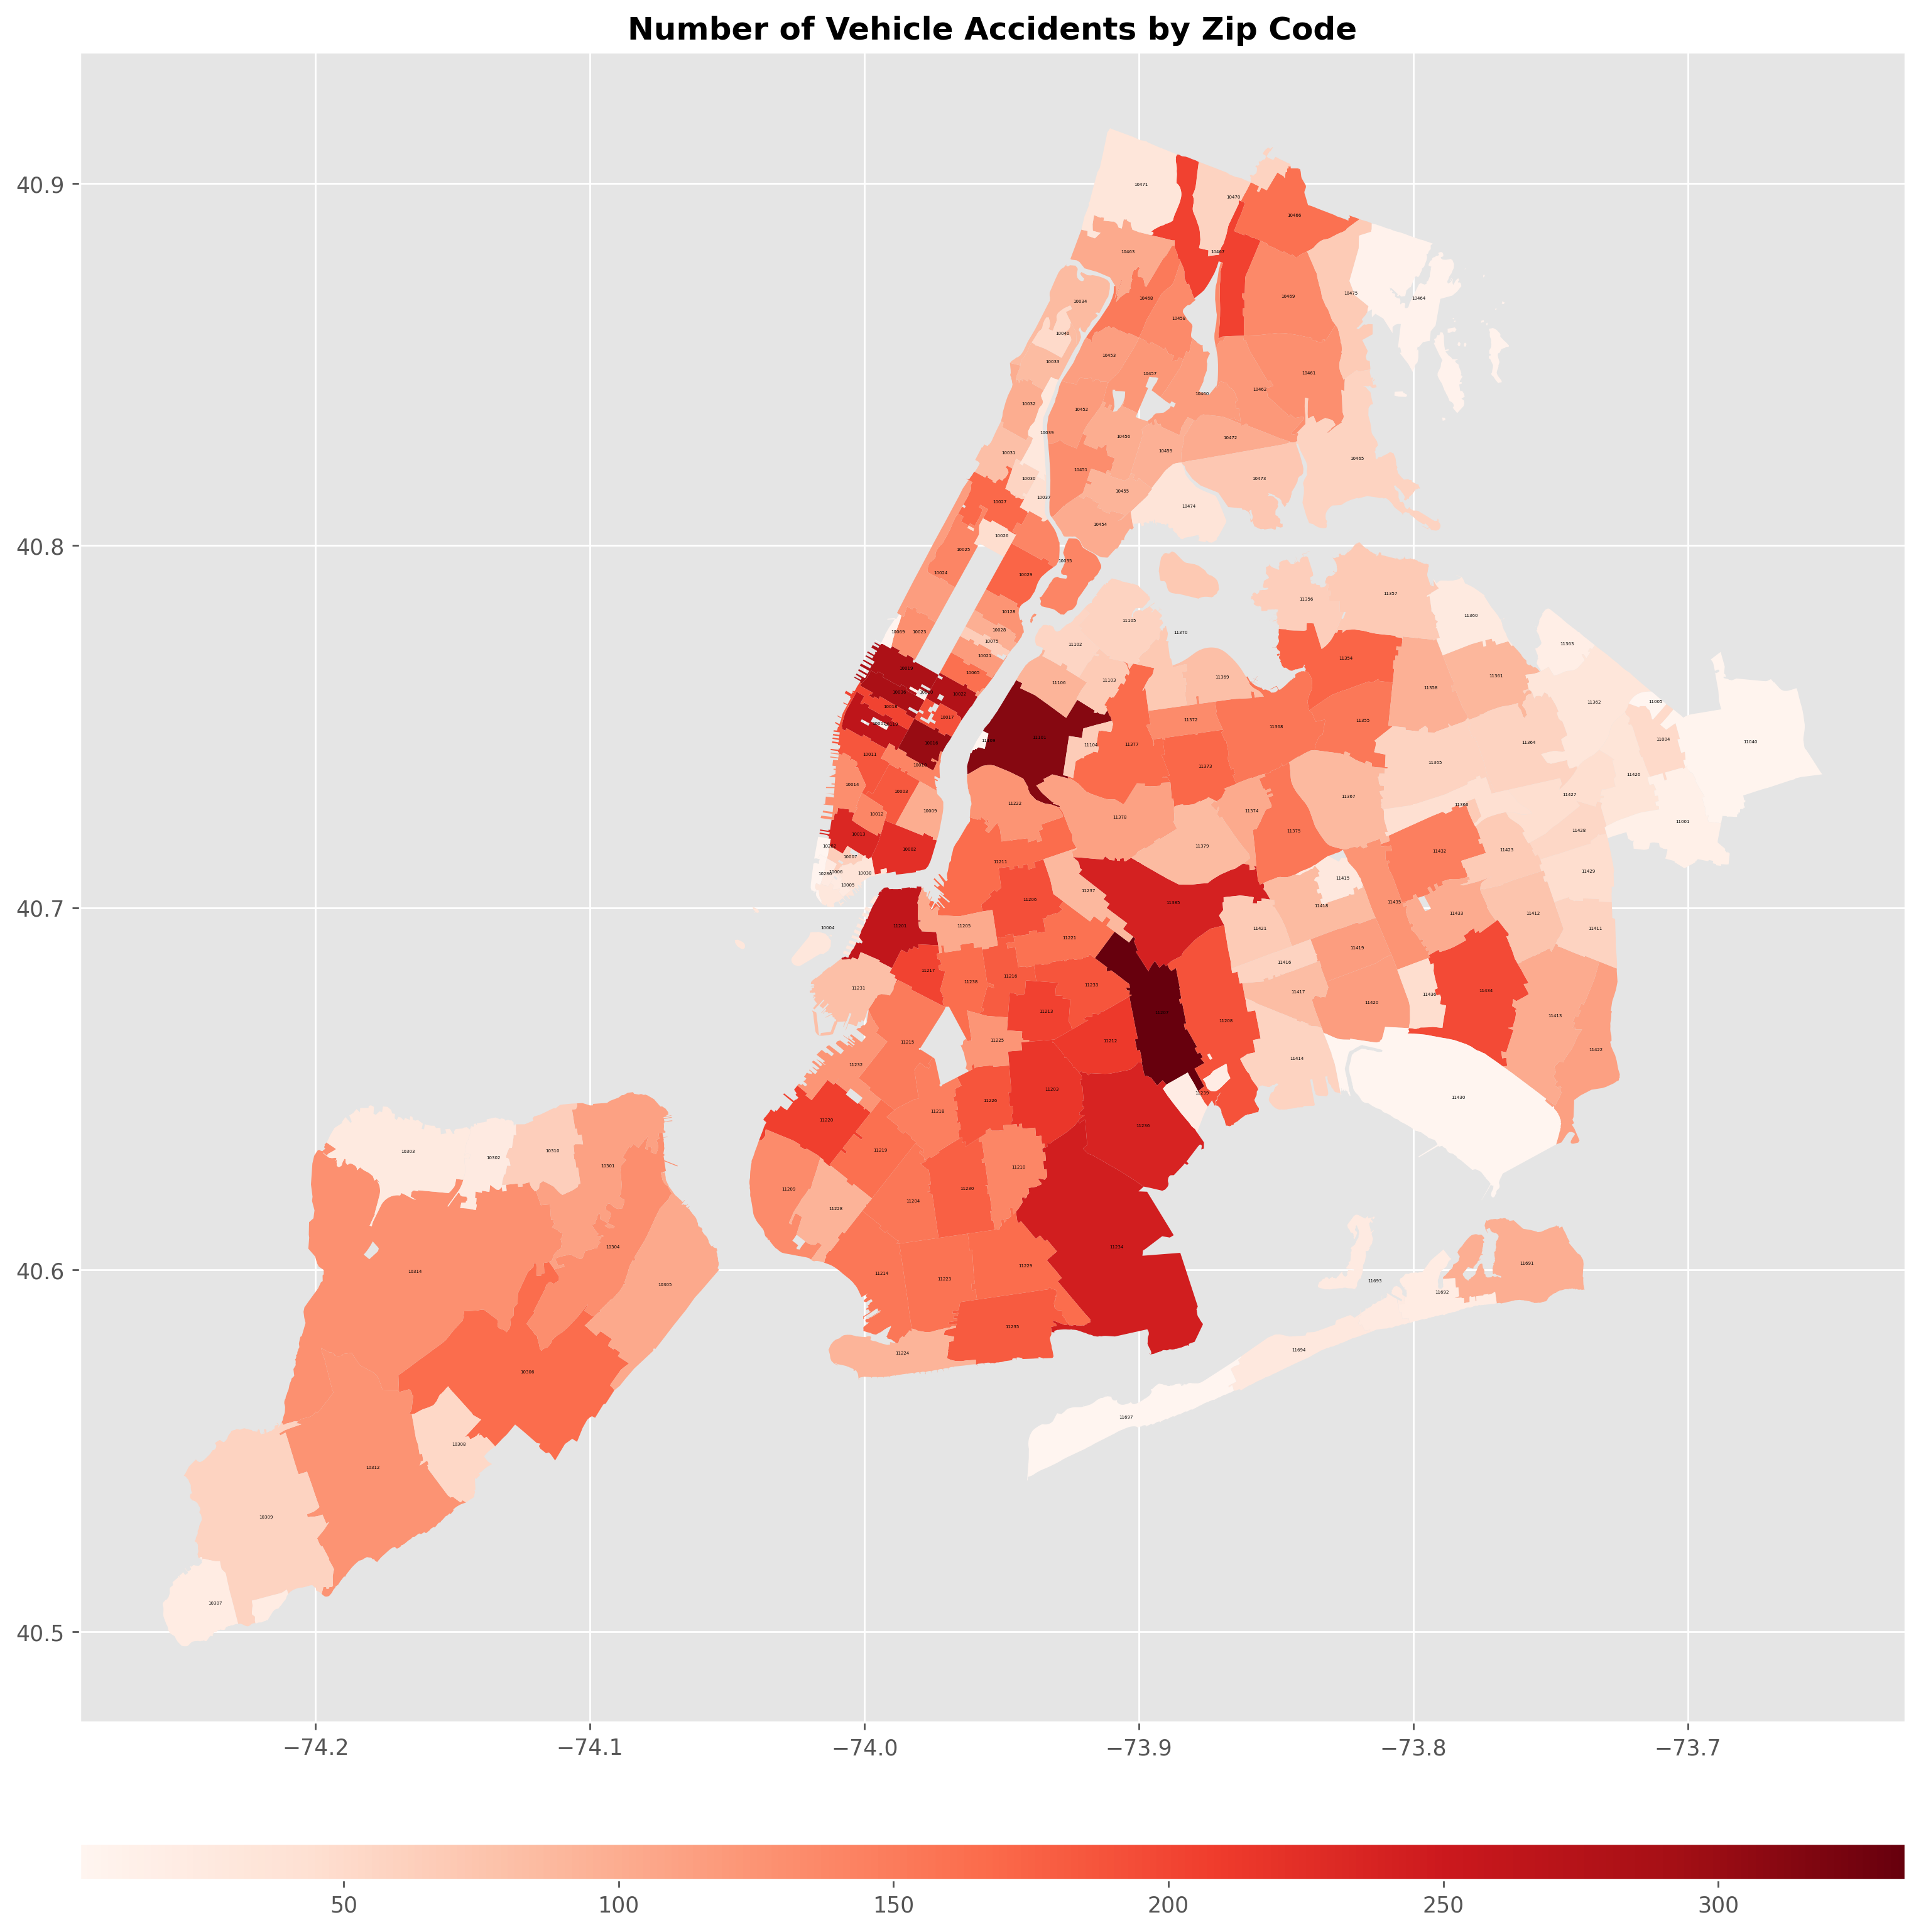

In [17]:
grouped=df.groupby('Zip Code')['Collision_Id'].count().reset_index()
grouped=grouped.merge(zips[['GEOID10','geometry']],left_on='Zip Code',right_on='GEOID10').sort_values('Collision_Id',ascending=False)
grouped=geopandas.GeoDataFrame(grouped)
grouped['X']=grouped['geometry'].centroid.x
grouped['Y']=grouped['geometry'].centroid.y


fig,ax=plt.subplots(figsize=(15,20),dpi=250)
grouped.plot(ax=ax,column='Collision_Id',cmap='Reds',legend=True,
             legend_kwds={'orientation':'horizontal','pad':0.05,'aspect':50})
for i in range(len(grouped)):
    plt.text(grouped['X'][i],grouped['Y'][i],grouped['Zip Code'][i],size=2)
plt.title('Number of Vehicle Accidents by Zip Code',fontweight='bold')
plt.show()

In [23]:
# Creating Folium Map

coordinates=[(lat,long) for lat,long in zip(df['Latitude'],df['Longitude'])]

m=grouped.explore(tiles='cartodb dark_matter',column='Collision_Id',cmap='Reds',zoom_start=10.5)
plugins.HeatMap(data=coordinates,radius=10,min_opacity=0.01,blur=2).add_to(m)
folium.LayerControl().add_to(m)
m

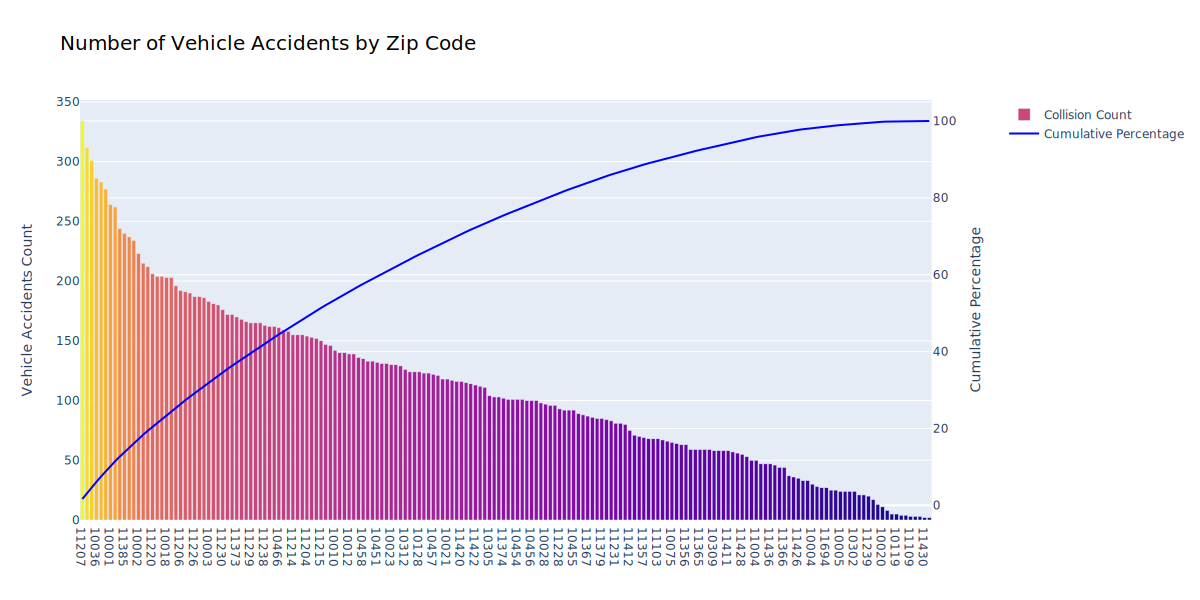

In [12]:
grouped['CumPercentage']=(grouped['Collision_Id']/grouped['Collision_Id'].sum()*100).cumsum()

fig=make_subplots(specs=[[{'secondary_y':True}]])

trace1=go.Bar(x=grouped['Zip Code'],y=grouped['Collision_Id'],name='Collision Count',hovertext=grouped['Zip Code'])
trace2=go.Line(x=grouped['Zip Code'],y=grouped['CumPercentage'],name='Cumulative Percentage')

fig.add_trace(trace1,secondary_y=False)
fig.add_trace(trace2,secondary_y=True)

fig.update_traces(marker=dict(color=grouped['Collision_Id']),secondary_y=False)
fig.update_traces(marker=dict(color='blue'),secondary_y=True)

fig.update_layout(title=dict(text='Number of Vehicle Accidents by Zip Code',font_size=20,font_family='Arial Black',font_color='black'),
                 height=600,width=1200,hovermode='x unified')
fig.update_yaxes(secondary_y=False,title_text='Vehicle Accidents Count')
fig.update_yaxes(secondary_y=True,title_text='Cumulative Percentage')
fig.show('svg')

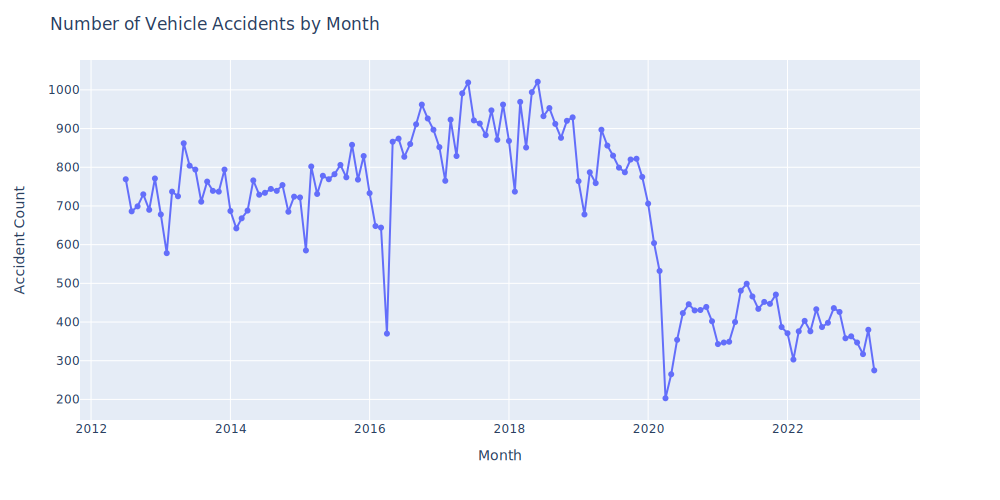

In [13]:
grouped=df.groupby(df['Crash Date'].dt.to_period('M'))['Collision_Id'].count()

fig=px.line(x=grouped.index.astype(str),y=grouped.values,markers=True)
fig.update_layout(title=dict(text='Number of Vehicle Accidents by Month',font_family='Arial Black'),hovermode='x unified',height=500,width=1000)
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Accident Count')
fig.show('svg')

In [14]:
df['Crash Time']=df['Crash Time'].str.split(':').str[0].astype(int)

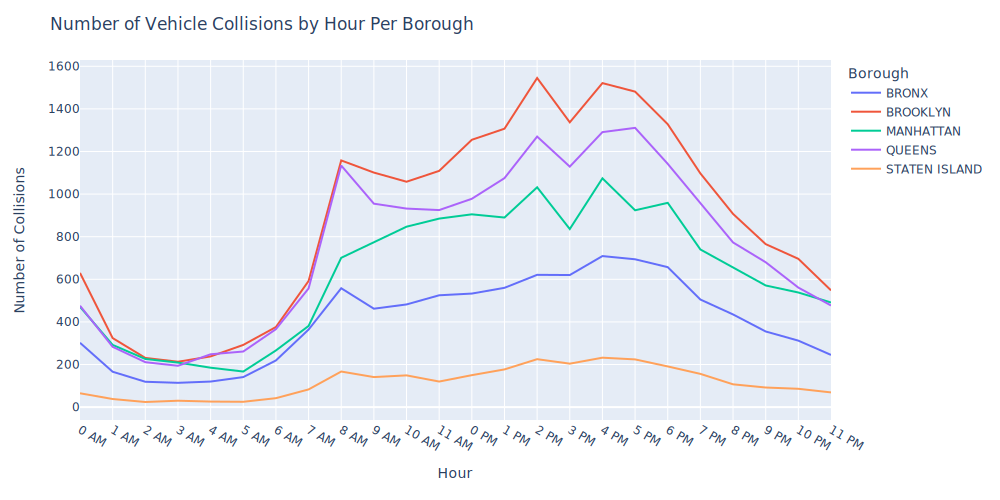

In [15]:
grouped=df.groupby(['Borough','Crash Time'])['Collision_Id'].count().reset_index()
grouped['Crash Time']=grouped['Crash Time'].apply(lambda x: f'{x} AM' if x<12 else f'{x-12} PM')

fig=px.line(grouped,x='Crash Time',y='Collision_Id',color='Borough')
fig.update_layout(title=dict(text='Number of Vehicle Collisions by Hour Per Borough',font_family='Arial Black'),height=500,width=1000)
fig.update_xaxes(title='Hour')
fig.update_yaxes(title='Number of Collisions')
fig.show('svg')

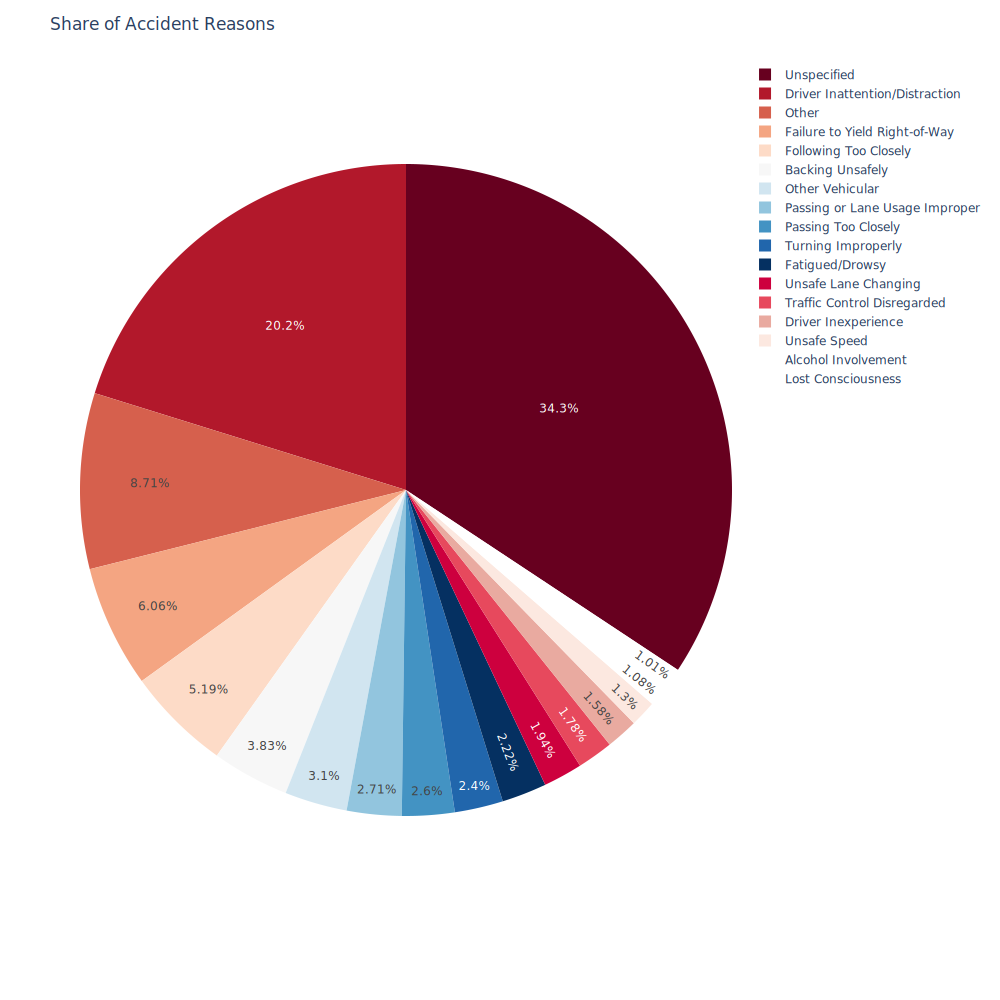

In [16]:
grouped=df['Contributing Factor Vehicle 1'].value_counts(normalize=True).reset_index()
grouped['index']=grouped.apply(lambda x:x['index'] if x['Contributing Factor Vehicle 1']>0.01 else 'Other',axis=1)

fig=px.pie(grouped,names='index',values='Contributing Factor Vehicle 1',hover_name='index',hole=0,
          color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title=dict(text='Share of Accident Reasons',font_family='Arial Black'),height=1000,width=1000)
#fig.update_traces(pull=[0+i*0.02 for i in range(len(grouped))])
fig.show('svg')